# 

In [2]:
%run ../utils-notebook/load_data.py
%run ../utils-notebook/plot.py
%run ../utils-notebook/imports.py
%run ../utils-notebook/dimensionality_reduction.py
%run ../utils-notebook/clustering.py
%run ../utils-notebook/validate.py

In [3]:
X, y = load_w2v(5000)


c:\Users\acero\Work_Research\DRZoom\src\experiments\17_HDBSCAN
c:\Users\acero\Work_Research\DRZoom\src\experiments\utils-notebook
Number of words in the model: 3000000
shape of vector: (5000, 300)


In [16]:
from sklearn.preprocessing import normalize
X = normalize(X)

In [44]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=5,
                            min_samples=7,
                            cluster_selection_method='eom',
                            max_cluster_size=1000,
                            gen_min_span_tree=True)
clusterer.fit(X)
labels = clusterer.labels_
probabilities = clusterer.probabilities_
print(len(set(labels)) - (1 if -1 in labels else 0))  # ノイズを除いたクラスタ数


38


In [40]:
labels = clusterer.labels_



# DBSCANの階層構造の切り出し

# MSTを特定のλで切ったときのクラスタ

<Axes: ylabel='$\\lambda$ value'>

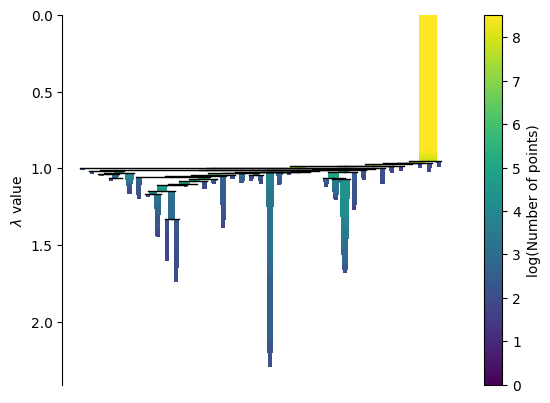

In [45]:
clusterer.condensed_tree_.plot(leaf_separation=0.5, log_size=True, max_rectangles_per_icicle=10)

In [32]:
lam = 1
condensed_tree = clusterer.condensed_tree_.to_pandas()
min_lam = condensed_tree['lambda_val'].min()
max_lam = condensed_tree['lambda_val'].max()
print(f"Min lambda: {min_lam}, Max lambda: {max_lam}")
for lam in np.linspace(min_lam, max_lam-1, 10):
    print(f"Lambda: {lam}")
    labels = clusterer.single_linkage_tree_.get_clusters(lam)
    print(np.unique(labels))



Min lambda: 0.7634536794615071, Max lambda: 2.2939852868517216
Lambda: 0.7634536794615071
[-1  0  1  2  3  4]
Lambda: 0.8224016358381976
[-1  0  1  2  3  4  5]
Lambda: 0.8813495922148882
[-1  0  1  2  3  4  5  6  7  8]
Lambda: 0.9402975485915787
[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Lambda: 0.9992455049682691
[-1  0  1  2  3  4  5]
Lambda: 1.0581934613449597
[-1  0]
Lambda: 1.11714141772165
[-1  0]
Lambda: 1.1760893740983407
[-1  0]
Lambda: 1.235037330475031
[-1  0]
Lambda: 1.2939852868517216
[-1  0]


# クラスタから代表点を選ぶ

In [68]:
clusterer.condensed_tree_._select_clusters()

[5002.0,
 5004.0,
 5006.0,
 5008.0,
 5010.0,
 5012.0,
 5014.0,
 5015.0,
 5018.0,
 5020.0,
 5024.0,
 5027.0,
 5030.0,
 5031.0,
 5033.0,
 5034.0,
 5036.0,
 5037.0,
 5038.0,
 5042.0,
 5044.0,
 5046.0,
 5048.0,
 5050.0,
 5053.0,
 5054.0,
 5056.0,
 5058.0,
 5060.0,
 5061.0,
 5064.0,
 5066.0,
 5068.0,
 5070.0,
 5073.0,
 5074.0,
 5075.0,
 5076.0]

In [71]:
def exemplars(cluster_id, raw_tree):
    
    # Just the cluster elements of the tree, excluding singleton points
    cluster_tree = raw_tree[raw_tree['child_size'] > 1]
    # Get the leaf cluster nodes under the cluster we are considering
    leaves = hdbscan.plots._recurse_leaf_dfs(cluster_tree, cluster_id)
    # Now collect up the last remaining points of each leaf cluster (the heart of the leaf)
    # print(f"leave num: {len(leaves)}")
    result = np.array([])
    for leaf in leaves:
        max_lambda = raw_tree['lambda_val'][raw_tree['parent'] == leaf].max() if len(raw_tree['lambda_val'][raw_tree['parent'] == leaf]) > 0 else 0
        points = raw_tree['child'][(raw_tree['parent'] == leaf) &
                                   (raw_tree['lambda_val'] == max_lambda)]
        result = np.hstack((result, points))
    return result

In [51]:
clusterer.condensed_tree_._raw_tree

array([(5000,    0, 0.76345368, 1), (5000, 3378, 0.8070868 , 1),
       (5000, 4737, 0.81540527, 1), ..., (5076,   84, 1.44522494, 1),
       (5076,  499, 1.44522494, 1), (5076, 4991, 1.44522494, 1)],
      dtype=[('parent', '<i8'), ('child', '<i8'), ('lambda_val', '<f8'), ('child_size', '<i8')])

In [72]:

for i in clusterer.condensed_tree_._select_clusters():
    print(f"Cluster {i}:")
    selected_exemplars = exemplars(i, clusterer.condensed_tree_._raw_tree)
    print("Selected exemplars indices:", selected_exemplars)

Cluster 5002.0:
Selected exemplars indices: [2460.  979.  481. 3201.  575.]
Cluster 5004.0:
Selected exemplars indices: [2146. 1902. 3581. 4883. 3708.]
Cluster 5006.0:
Selected exemplars indices: [3076. 1493. 3156.  636. 2404. 2216.]
Cluster 5008.0:
Selected exemplars indices: [1243.  489.  243.  637.  561.]
Cluster 5010.0:
Selected exemplars indices: [2868. 1809. 2818. 4380. 4594.]
Cluster 5012.0:
Selected exemplars indices: [1042.  590. 1985. 4965. 1678.]
Cluster 5014.0:
Selected exemplars indices: [1388. 2749. 1384. 3177. 2260.]
Cluster 5015.0:
Selected exemplars indices: [1360. 1011.  454.  921. 2041.  845.]
Cluster 5018.0:
Selected exemplars indices: [ 422.  559.  786.  615. 2148.]
Cluster 5020.0:
Selected exemplars indices: [ 753. 1741. 1717.  983. 1299.]
Cluster 5024.0:
Selected exemplars indices: [2934. 2885. 4372. 4711. 3223.]
Cluster 5027.0:
Selected exemplars indices: [4227. 1942.  285. 2903. 1030. 1599.]
Cluster 5030.0:
Selected exemplars indices: [3159. 2031. 1704. 2946. 2